## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
 Description from Kaggle:In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.  

Построить модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в Data Science соревновании.

## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [3]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [4]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format ='%Y-%m-%d %H:%M:%S')
print(min(taxi_data['pickup_datetime']))
print(max(taxi_data['pickup_datetime']))

2016-01-01 00:00:17
2016-06-30 23:59:39


Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [5]:
taxi_data.isnull().mean()

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

Посмотрим на статистические характеристики некоторых признаков. 


In [6]:
display(taxi_data.describe())

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,2016-04-01 10:10:24.940037120,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
min,1.000000e+00,2016-01-01 00:00:17,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,2016-02-17 16:46:04.249999872,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,2016-04-01 17:19:40,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2016-05-15 03:56:08.750000128,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,2016-06-30 23:59:39,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06
std,4.987772e-01,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

In [7]:
def add_datetime_features(data):
    data['pickup_date'] = data['pickup_datetime'].dt.date
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.day_of_week
    return data

taxi_data = add_datetime_features(taxi_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5


Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 


In [8]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
display(holiday_data)
#напишем функцию, которая возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday
def add_holiday_features(data, holiday_data):
    #переведем сначала столбец 'date' в формат datetime
    holiday_data['date'] = pd.to_datetime(holiday_data['date'], format ='%Y-%m-%d').dt.date
    hld_list = holiday_data['date'].to_list() #переведем данные столбца в список
    #напишем функцию бинарного кодирования 'выходной-не выходной'
    def get_holiday(day):
        if day in hld_list:
            return 1
        else:
            return 0
    data['pickup_holiday'] = data['pickup_date'].apply(get_holiday) #закодируем столбец
    return data  

taxi_data = add_holiday_features(taxi_data, holiday_data)

print(taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median())

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day
5,Monday,2016-05-30,Memorial Day
6,Sunday,2016-06-19,Father's Day
7,Monday,2016-07-04,Independence Day
8,Monday,2016-09-05,Labor Day
9,Monday,2016-10-10,Columbus Day


585.0


Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

В результате объединения таблиц у нас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

In [9]:
osrm_data = pd.read_csv('data/osrm_data_train.csv') #cчитываем osrm данные 
#напишем функцию, которая возвращает обновленную таблицу с данными о поездках с добавленными в нее 3-мя нужными столбцами
def add_osrm_features(taxi_data,osrm_data):
    osrm_new = osrm_data[['id','total_distance','total_travel_time', 'number_of_steps']]
    taxi_data = taxi_data.join(osrm_new.set_index('id'),on='id',how='left') #объединяем таблицу слева по индексу с таблицей osrm
    return taxi_data

taxi_data = add_osrm_features(taxi_data, osrm_data)
print(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median())
print(taxi_data.isnull().value_counts())

372.5
id     vendor_id  pickup_datetime  dropoff_datetime  passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  store_and_fwd_flag  trip_duration  pickup_date  pickup_hour  pickup_day_of_week  pickup_holiday  total_distance  total_travel_time  number_of_steps
False  False      False            False             False            False             False            False              False             False               False          False        False        False               False           False           False              False              1458643
                                                                                                                                                                                                                                               True            True               True                     1
Name: count, dtype: int64


In [10]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

In [11]:
def add_geographical_features(taxi_data):
    #присваиваем соответствующим переменным векторы-столбцы, чтобы не путаться с очередностью
    lat1 = taxi_data['pickup_latitude'] 
    lng1 = taxi_data['pickup_longitude']
    lat2 = taxi_data['dropoff_latitude']
    lng2 = taxi_data['dropoff_longitude']
    taxi_data['haversine_distance'] = get_haversine_distance(lat1,lng1,lat2,lng2)
    taxi_data['direction'] = get_angle_direction(lat1, lng1, lat2, lng2)
    return taxi_data

taxi_data = add_geographical_features(taxi_data)
display(taxi_data.head())
taxi_data['haversine_distance'].median()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0,1.498521,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0,1.805507,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0,11060.8,767.6,16.0,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0,1.188588,179.473585


2.0937171329263693

Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [12]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

#Создаем функцию, которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации
def add_cluster_features(taxi_data,kmeans):
    coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
    taxi_data['geo_cluster'] = kmeans.predict(coords) #составляем столбец из предсказанных кластеров
    return taxi_data
taxi_data = add_cluster_features(taxi_data,kmeans)
display(taxi_data['geo_cluster'].value_counts())

c:\Users\ThinkBook\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


geo_cluster
1    592117
0    392108
6    340489
8     45518
4     40234
5     32799
7     15355
9        18
3         4
2         2
Name: count, dtype: int64

Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

В результате объединения у нас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

In [13]:
weather_data = pd.read_csv('data/weather_data.csv') #считываем файл с информацией о погоде
def add_weather_features(taxi_data, weather_data): #реализуем функцию, которая добавит в нашу таблицу данные о погоде
    weather_data['time'] = pd.to_datetime(weather_data['time'])
    weather_data['date'] = weather_data['time'].dt.date
    weather_data['hour'] = weather_data['time'].dt.hour
    weather_columns = [
        'date', 'hour', 'temperature', 'visibility',
        'wind speed', 'precip', 'events'
    ]
    taxi_data = taxi_data.merge(
        weather_data[weather_columns], 
        left_on=['pickup_date', 'pickup_hour'], 
        right_on=['date', 'hour'],
        how='left'
    )
    taxi_data = taxi_data.drop(['date', 'hour'], axis=1)
    return taxi_data

taxi_data = add_weather_features(taxi_data, weather_data)
print(taxi_data['events'].value_counts())
print(round((taxi_data['visibility'].isnull().mean() * 100),2))

events
Rain    58300
Snow    13126
Fog         1
Name: count, dtype: int64
0.82


Реализуем функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполним медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируем данные по столбцу pickup_date и рассчитаем медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполним пропуски. 
Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам. 

In [14]:
def fill_null_weather_data(data): #создадим функцию, которая будет заполнять пропуски в наших данных
    cols_to_fill = ['temperature', 'visibility', 'wind speed', 'precip']
    #в столбцах с данными о погоде, заполним пропуски в зависимости от даты поездки
    for col in cols_to_fill:
        data[col] = data[col].fillna(data.groupby('pickup_date')[col].transform('median')) 
    
    data['events'] = data['events'].fillna('None')

    cols_to_fill_2 = ['total_distance', 'total_travel_time', 'number_of_steps']

    for col in cols_to_fill_2:
        data[col] = data[col].fillna(data[col].median())
    return data

taxi_data = fill_null_weather_data(taxi_data)
print(taxi_data['temperature'].median())
print(taxi_data.isnull().mean())

11.1
id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
pickup_date           0.0
pickup_hour           0.0
pickup_day_of_week    0.0
pickup_holiday        0.0
total_distance        0.0
total_travel_time     0.0
number_of_steps       0.0
haversine_distance    0.0
direction             0.0
geo_cluster           0.0
temperature           0.0
visibility            0.0
wind speed            0.0
precip                0.0
events                0.0
dtype: float64


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


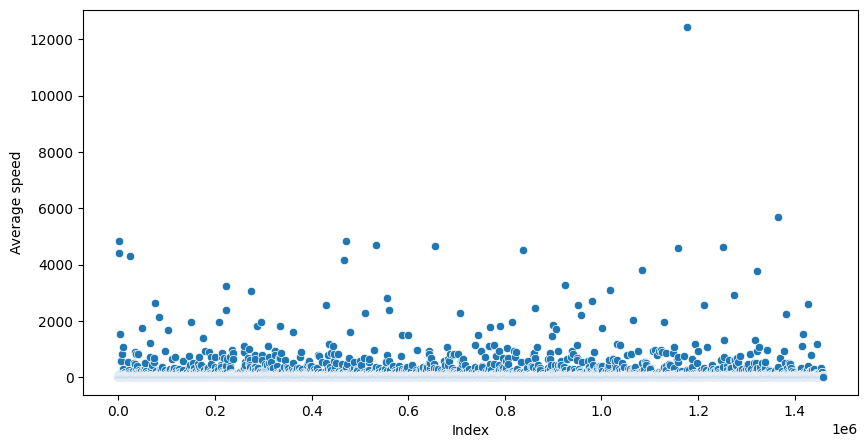

In [15]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


Найдем поездки, длительность которых превышает 24 часа, и удалим их.
Найдем поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалимих из данных. 

In [16]:
#выбираем строки с выбросами по длительности поездки - более 24 часов, то есть 86400 секунд
too_long = taxi_data[taxi_data['trip_duration']>86400]
print(len(too_long))
taxi_data = taxi_data.drop(too_long.index,axis=0) #удаляем эти строки из таблицы
print(taxi_data.shape[0])

too_fast = taxi_data[avg_speed>300] #выбираем строки с длительностью поездки более 300км/ч, используя формулу выше
print(len(too_fast))
taxi_data = taxi_data.drop(too_fast.index,axis=0) #удаляем эти строки из таблицы
print(taxi_data.shape[0])

4
1458640
407


C:\Users\ThinkBook\AppData\Local\Temp\ipykernel_11856\1320162433.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  too_fast = taxi_data[avg_speed>300] #выбираем строки с длительностью поездки более 300км/ч, используя формулу выше


1458233


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. 

Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [17]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделаем предположение, является ли полученное распределение нормальным.
Проверим свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

c:\Users\ThinkBook\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


0.0


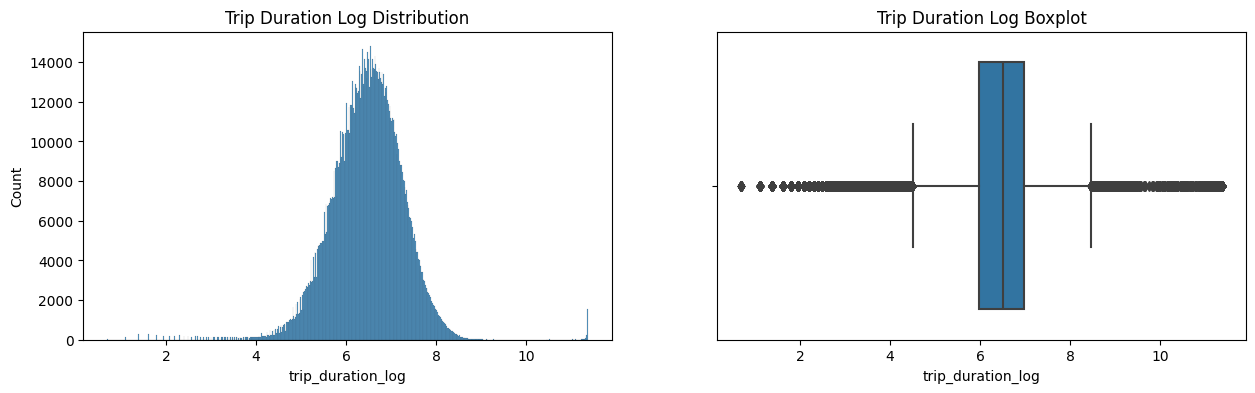

In [18]:
#построим гистограмму и коробчатую диаграмму длительности поездок в log масштабе
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(taxi_data, x='trip_duration_log', ax=axes[0]);
histplot.set_title('Trip Duration Log Distribution');
boxplot = sns.boxplot(taxi_data, x='trip_duration_log', ax=axes[1]);
boxplot.set_title('Trip Duration Log Boxplot');

#Проверим гипотезу о нормальности распределения длительности поездки в логарифмическом масштабе с помощью теста Д’Агостино
print(stats.normaltest(taxi_data['trip_duration_log'])[1]) 

Распределение согласно тесту не является нормальным.

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 
Сравним два распределения между собой.

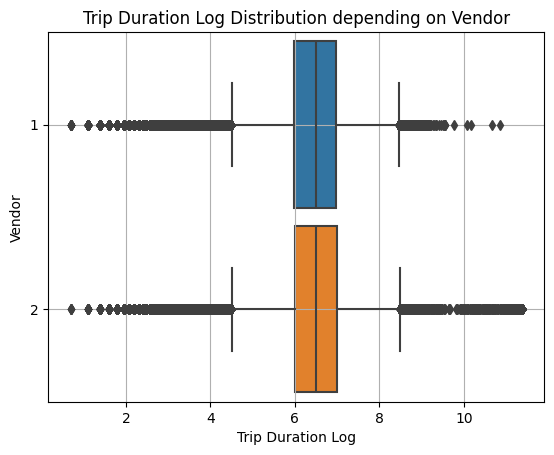

In [ ]:
#Построим визуализацию сравнения распределения длительности поездки в log масштабе в зависимости от таксопарка
boxplot = sns.boxplot(
    data=taxi_data,
    y='vendor_id',
    x='trip_duration_log',
    orient='h',
    width=0.9
)
boxplot.set_title('Trip Duration Log Distribution depending on Vendor');
boxplot.set_xlabel('Trip Duration Log');
boxplot.set_ylabel('Vendor');
boxplot.grid()


Видим, что распределение длительности поездки в log масштабе не зависит от таксопарка

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 
Сравним два распределения между собой.

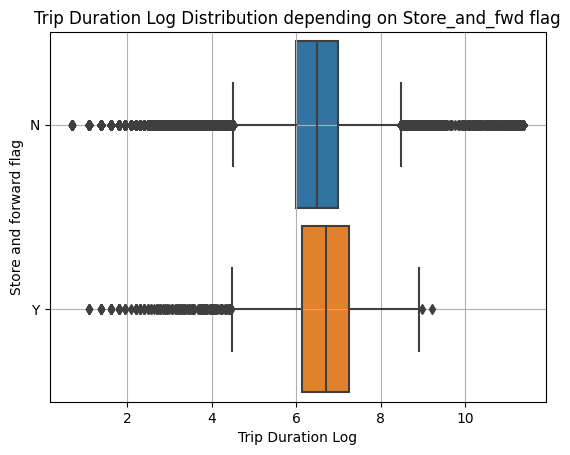

In [ ]:
#Построим визуализацию распределения длительности поездки в log масштабе в зависисмости от отправки сообщения поставщику
boxplot = sns.boxplot(
    data=taxi_data,
    y='store_and_fwd_flag',
    x='trip_duration_log',
    orient='h',
    width=0.9
)
boxplot.set_title('Trip Duration Log Distribution depending on Store_and_fwd flag');
boxplot.set_xlabel('Trip Duration Log');
boxplot.set_ylabel('Store and forward flag');
boxplot.grid()

Если внимательно присмотреться к распределению длительности поездок в зависимости от признака store_and_fwd_flag, 
становится ясно, что наиболее длительные поездки принадлежат к группе N (не хранить и не пересылать поездку). 
Таким образом, флаг сохраняется только для кратковременных поездок, а для аномальных многочасовых — не сохраняется. Соответственно, возможно, есть зависимость от этого признака.

Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

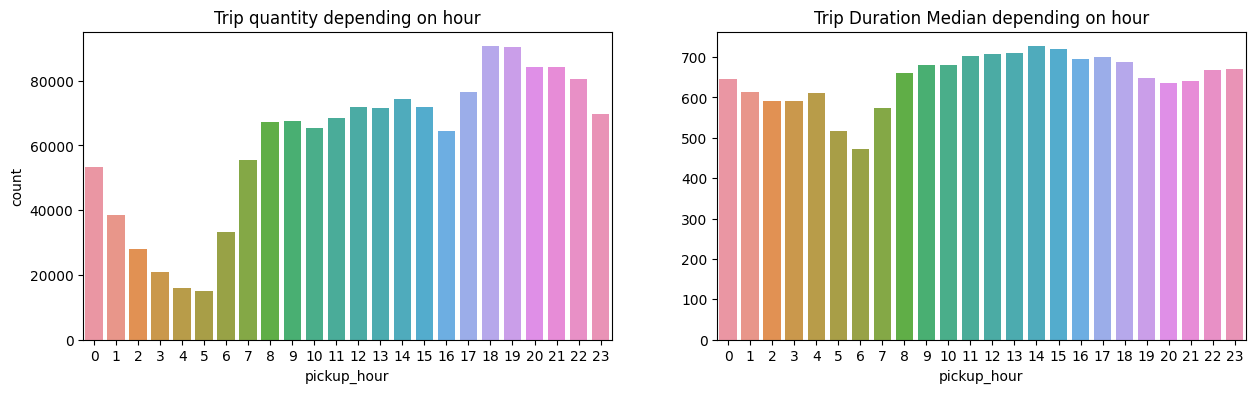

In [21]:
#Сгруппируем данные по часам начала поездки и посчитаем медианы длительности поездки
grouped = taxi_data.groupby('pickup_hour')['trip_duration'].median() 
#Построим графики распределения по часам количества поездок и медианн длительности
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.countplot(taxi_data, x='pickup_hour', ax=axes[0]);
histplot.set_title('Trip quantity depending on hour');
boxplot = sns.barplot(x=grouped.index, y=grouped.values, ax=axes[1]);
boxplot.set_title('Trip Duration Median depending on hour');


Видим, что самые длительные поездки совершаются вечером (в 18-19 часов), а самая большая медиана расположена между 14-ю и 15-ю часами.

Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.


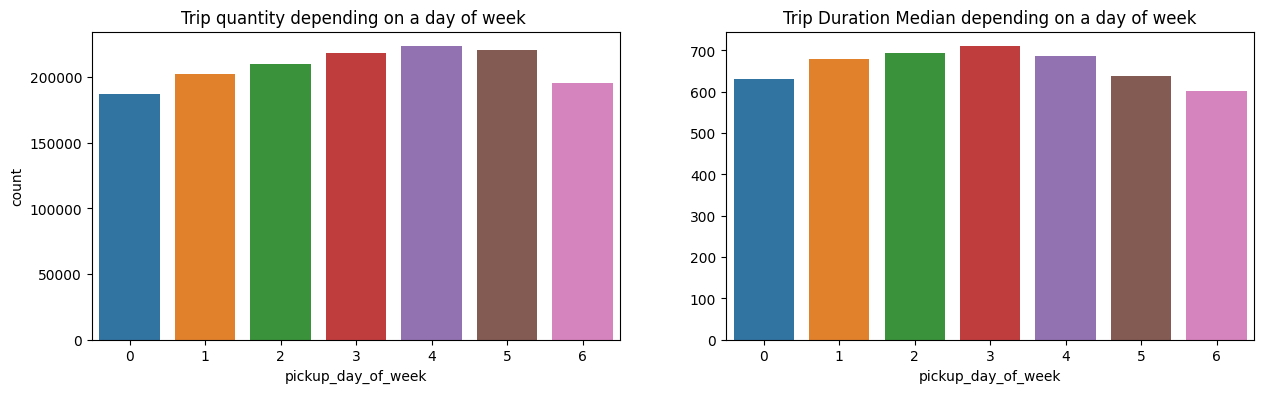

In [22]:
#Сгруппируем данные по дням недели поездки и посчитаем медианы длительности поездки
grouped_dow = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()

#Построим графики распределения по дням недели количества поездок и медианн длительности
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.countplot(taxi_data, x='pickup_day_of_week', ax=axes[0]);
histplot.set_title('Trip quantity depending on a day of week ');
boxplot = sns.barplot(x=grouped_dow.index, y=grouped_dow.values, ax=axes[1]);
boxplot.set_title('Trip Duration Median depending on a day of week');

На графике видно, что наибольшее количество поездок на такси происходит в пятницу и субботу, а в четвер они наиболее продолжительные.

Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируем полученную сводную таблицу с помощью тепловой карты.

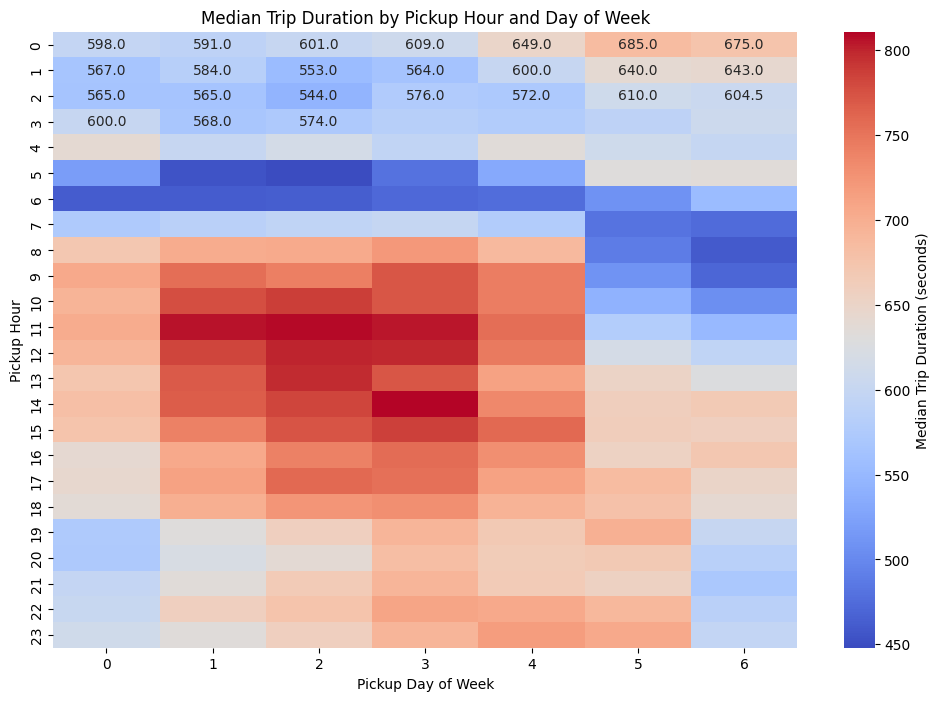

In [23]:
pivot_table = taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".1f", cbar_kws={'label': 'Median Trip Duration (seconds)'})

# Настройка подписей и заголовка
plt.xlabel('Pickup Day of Week')
plt.ylabel('Pickup Hour')
plt.title('Median Trip Duration by Pickup Hour and Day of Week')

# Отображение тепловой карты
plt.show()

#Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.
#Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

Построим две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавим следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)


8


Text(0.5, 1.0, 'Geographical Distribution of Taxi Dropoffs by Cluster in NYC')

C:\Users\ThinkBook\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\ThinkBook\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


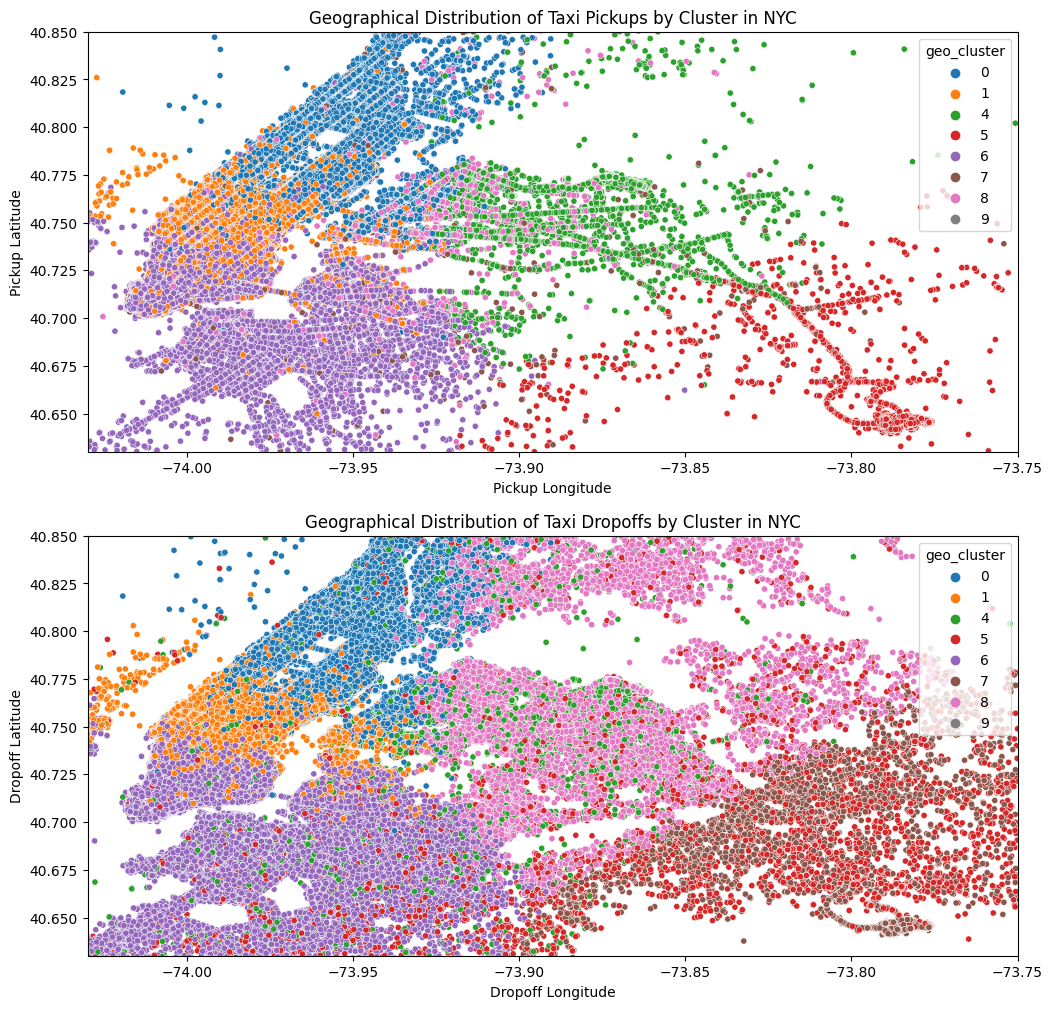

In [24]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

#фильтруем данные по координатам
filtered_data = taxi_data[(taxi_data['pickup_longitude'] >= city_long_border[0]) & 
                          (taxi_data['dropoff_longitude'] <= city_long_border[1]) &
                          (taxi_data['pickup_latitude'] >= city_lat_border[0]) &
                          (taxi_data['dropoff_latitude'] <= city_lat_border[1])]

print(filtered_data['geo_cluster'].nunique())

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
scatter1 = sns.scatterplot(
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster', #Цвет точек в зависимости от кластера
    palette='tab10',  # Палитра для 10 различных кластеров
    data=filtered_data,
    s=20,# Размер точек
    ax=axes[0]
)
scatter1.set_xlabel('Pickup Longitude');# Настройка подписей и заголовка
scatter1.set_ylabel('Pickup Latitude');
# Настройка границ осей
scatter1.set_xlim(city_long_border)
scatter1.set_ylim(city_lat_border)
scatter1.set_title('Geographical Distribution of Taxi Pickups by Cluster in NYC')

scatter2 = sns.scatterplot(
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='geo_cluster',#Цвет точек в зависимости от кластера
    palette='tab10',  # Палитра для 10 различных кластеров
    data=filtered_data,
    s=20,# Размер точек
    ax=axes[1]
)
scatter2.set_xlabel('Dropoff Longitude');# Настройка подписей и заголовка
scatter2.set_ylabel('Dropoff Latitude');
# Настройка границ осей
scatter2.set_xlim(city_long_border)
scatter2.set_ylim(city_lat_border)
scatter2.set_title('Geographical Distribution of Taxi Dropoffs by Cluster in NYC')

Видим, что два из десяти кластеров находятся вне Нью-Йорка.

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [25]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [26]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,0,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,6,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,6,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,6,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,0,9.4,16.1,9.3,0.0,None,6.077642


Сразу позаботимся об очевидных неинформативных и избыточных признаках. 
Удалим неинформативные признаки, а также признаки, в которых есть утечка данных.


In [27]:
train_data = train_data.drop(['id','dropoff_datetime'],axis=1)
print(train_data.shape[1])

25


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [28]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)



Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

In [29]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
print(round(train_data['vendor_id'].mean(),2))
print(round(train_data['store_and_fwd_flag'].mean(),3))

0.53
0.006


Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставим в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установим значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder получим безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

In [30]:
from sklearn.preprocessing import OneHotEncoder
cat_columns = ['pickup_day_of_week', 'geo_cluster', 'events']

# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

# Кодируем признаки
encoded_data = one_hot_encoder.fit_transform(train_data[cat_columns])

# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out(cat_columns)

# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(encoded_data.toarray(), columns=column_names)

# Проверим результат
display(data_onehot.head())

,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Добавим полученную таблицу с закодированными признаками:

In [31]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(cat_columns, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [32]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [33]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуем по обучающей выборке, используя параметр score_func = f_regression.

In [34]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)

selected_features = selector.get_feature_names_out()
X_train = X_train[selected_features]
X_valid = X_valid[selected_features]

print(f'Отобранные признаки: {selector.get_feature_names_out()}')
print(f'Train Data shape: {X_train.shape}')
print(f'Test Data shape: {X_valid.shape}')

Отобранные признаки: ['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_1'
 'pickup_day_of_week_2' 'pickup_day_of_week_3' 'pickup_day_of_week_4'
 'pickup_day_of_week_5' 'pickup_day_of_week_6' 'geo_cluster_1'
 'geo_cluster_4' 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_8']
Train Data shape: (977016, 25)
Test Data shape: (481217, 25)


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. 

In [35]:
# Создание объекта MinMaxScaler
scaler = preprocessing.MinMaxScaler()

# Масштабируем обучающие данные
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Масштабируем валидационные данные
X_valid_scaled = scaler.transform(X_valid)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns, index=X_valid.index)

print(round(X_valid_scaled['vendor_id'].mean(),2))

0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Линейная регрессия
Построим модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставьте по умолчанию.
Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.


In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# создаём модель линейной регрессии
model = LinearRegression()
#обучим модель на обучающей выборке
model.fit(X_train_scaled, y_train_log)

pred_train = model.predict(X_train_scaled)
pred_valid = model.predict(X_valid_scaled)

print('RMSLE score train: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, pred_train))))
print('RMSLE score valid: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, pred_valid))))

RMSLE score train: 0.534 %
RMSLE score valid: 0.536 %


### Полиномиальная регрессия 2-ой степени
Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставим в значение False.
Построим модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставим по умолчанию.

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
#Создаем полиномиальные признаки
poly = PolynomialFeatures(degree=2, include_bias=False)
# добавляем полиномиальные признаки
X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.fit_transform(X_valid_scaled)
model.fit(X_train_poly, y_train_log) #обучаем модель полиномиальной регрессии

pred_train_poly = model.predict(X_train_poly)
pred_valid_poly = model.predict(X_valid_poly)

print('RMSLE score train: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, pred_train_poly))))
print('RMSLE score valid: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, pred_valid_poly))))


RMSLE score train: 0.467 %
RMSLE score valid: 0.613 %


### Полиномиальная регрессия 2-ой степени с L2-регуляризацией
Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установим равным 1, остальные параметры оставьте по умолчанию.

In [38]:
# создаём модель линейной регрессии c L2-регуляризацией со значением параметра alpha=1
ridge = Ridge(alpha=1)
ridge.fit(X_train_poly, y_train_log)
pred_train_poly_l2 = ridge.predict(X_train_poly)
pred_valid_poly_l2 = ridge.predict(X_valid_poly)
print('RMSLE score train: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, pred_train_poly_l2))))
print('RMSLE score valid: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, pred_valid_poly_l2))))


RMSLE score train: 0.477 %
RMSLE score valid: 0.480 %


### DecisionTreeRegressor
Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

In [39]:
#Создаем объект класса дерево решений
dtr = tree.DecisionTreeRegressor(random_state=42) 
#Обучаем дерево 
dtr.fit(X_train_scaled, y_train_log)
#Делаем предсказание для тренировочной выборки и валидационной выборки
pred_train_dtr = dtr.predict(X_train_scaled)
pred_valid_dtr = dtr.predict(X_valid_scaled)
print('RMSLE score train: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, pred_train_dtr))))
print('RMSLE score valid: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, pred_valid_dtr))))

RMSLE score train: 0.003 %
RMSLE score valid: 0.565 %


### DecisionTreeRegressor с оптимизацией гиперпараметра max-depth
Переберем все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задаем равным 42.

Построим линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 
Найдем оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).


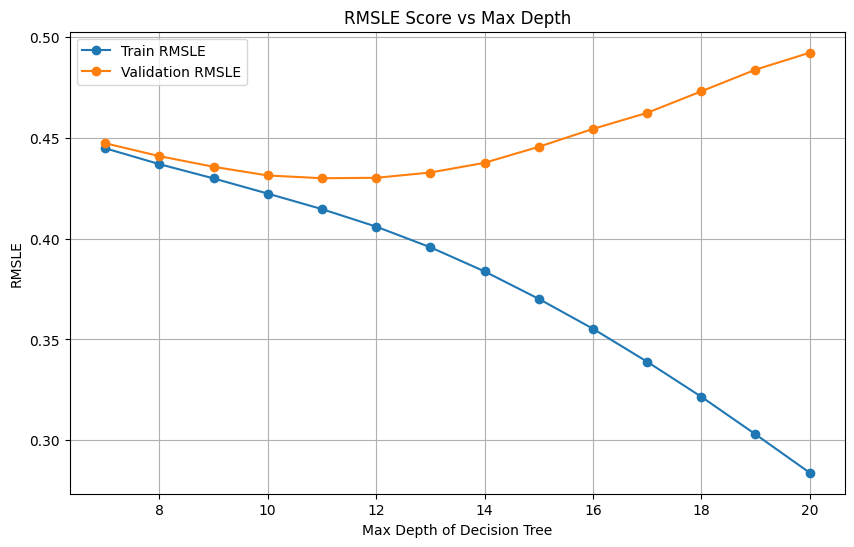

In [ ]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': list(np.linspace(7, 20, 14, dtype=int))}
            
grid_search_tree = GridSearchCV(estimator=dtr, param_grid = param_grid, cv=5, n_jobs = -1) 
grid_search_tree.fit(X_train_scaled, y_train_log)

# Списки для сохранения результатов
train_scores = []
valid_scores = []
# Извлекаем значения RMSLE для каждого значения max_depth
for depth in param_grid['max_depth']:
    # Обучаем модель с текущей глубиной
    dtr.set_params(max_depth=depth)
    dtr.fit(X_train_scaled, y_train_log)
    
    # Предсказания и расчет RMSLE на обучающей выборке
    pred_train = dtr.predict(X_train_scaled)
    rmsle_train = np.sqrt(mean_squared_error(y_train_log, pred_train))
    train_scores.append(rmsle_train)
    
    # Предсказания и расчет RMSLE на валидационной выборке
    pred_valid = dtr.predict(X_valid_scaled)
    rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, pred_valid))
    valid_scores.append(rmsle_valid)

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(param_grid['max_depth'], train_scores, label='Train RMSLE', marker='o')
plt.plot(param_grid['max_depth'], valid_scores, label='Validation RMSLE', marker='o')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('RMSLE')
plt.title('RMSLE Score vs Max Depth')
plt.legend()
plt.grid(True)
plt.show()

На графике ыидно, что оптимальным значением max-depth является 12. Установим этот параметр и сделаем предсказания.

In [ ]:
dtr.set_params(max_depth=12) 
dtr.fit(X_train_scaled, y_train_log)
pred_train = dtr.predict(X_train_scaled)
pred_valid = dtr.predict(X_valid_scaled)
print('RMSLE score train: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, pred_train))))
print('RMSLE score valid: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, pred_valid))))

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### RandomForestRegressor

Построим модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). В качестве гиперпараметров укажем следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

In [54]:
#Построим модель случайного леса с указанными параметрами
rf = ensemble.RandomForestRegressor(n_estimators=200,
                                    max_depth=12,
                                    criterion='squared_error',
                                    min_samples_split=20,
                                    random_state=42,
                                    verbose=True)
#Обучаем модель
rf.fit(X_train_scaled,y_train_log)
#Делаем предсказания
pred_train_rf = rf.predict(X_train_scaled)
pred_valid_rf = rf.predict(X_valid_scaled)
#Рассчитываем метрики
print('RMSLE score train: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, pred_train_rf))))
print('RMSLE score valid: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, pred_valid_rf))))



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 11.4min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 89.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   20.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s


RMSLE score train: 0.399 %
RMSLE score valid: 0.414 %


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   11.1s


### GradientBoostingRegressor
Построим модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используем в логарифмическом масштабе). В качестве гиперпараметров укажем следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=6, #максимальная глубина дерева
    n_estimators=100, #количество деревьев в ансамбле
    random_state=42,#датчик генератора случайных чисел
    min_samples_split= 30,
    verbose=True)

#Обучаем модель
gb.fit(X_train_scaled,y_train_log)
#Делаем предсказания
pred_train_gb = gb.predict(X_train_scaled)
pred_valid_gb = gb.predict(X_valid_scaled)
#Рассчитываем метрики
print('RMSLE score train: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, pred_train_gb))))
print('RMSLE score valid: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, pred_valid_gb))))

      Iter       Train Loss   Remaining Time 
         1           0.5859           11.12m
         2           0.5488           11.01m
         3           0.5151           10.91m
         4           0.4847           10.87m
         5           0.4572           10.76m
         6           0.4322           10.64m
         7           0.4096           10.50m
         8           0.3892           10.40m
         9           0.3707           10.36m
        10           0.3539           10.32m
        20           0.2518            9.14m
        30           0.2114            7.98m
        40           0.1931            7.08m
        50           0.1840            6.59m
        60           0.1786            5.14m
        70           0.1747            3.78m
        80           0.1717            2.49m
        90           0.1691            1.23m
       100           0.1674            0.00s
RMSLE score train: 0.409 %
RMSLE score valid: 0.413 %


### Вывод: Наилучший результат показала модель градиентного бустинга.

Построbvc столбчатую диаграмму коэффициентов значимости каждого из факторов.

In [69]:
#напишем функцию для ранжирования признаков
def feature_range(mname): #в качестве аргумента - переменная, которой присвоена ранее опробованная модель
    importances = mname.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("Ранги признаков для модели {}:".format(mname))
    for f in range(X_train_scaled.shape[1]):
        print(f'{X_train_scaled.columns[indices[f]]}:{importances[indices[f]]}')

fr = feature_range(gb)

import plotly.express as px
gb_features = pd.DataFrame(gb.feature_importances_, index=X_train_scaled.columns)
fig = px.bar(gb_features)
fig.show()

Ранги признаков для модели GradientBoostingRegressor(learning_rate=0.05, max_depth=6, min_samples_split=30,
                          random_state=42, verbose=True):
total_distance:0.6736699230047737
total_travel_time:0.18571761533763795
pickup_hour:0.057077569470312416
dropoff_latitude:0.020805064777372935
haversine_distance:0.017864542342964935
pickup_day_of_week_6:0.006839550638443936
number_of_steps:0.006122599045404556
dropoff_longitude:0.005705972184664731
pickup_longitude:0.005035502187257564
pickup_day_of_week_5:0.004818414170241091
vendor_id:0.004403023903871066
pickup_latitude:0.0028815756467126725
geo_cluster_1:0.002075446870229502
temperature:0.002014625486092792
pickup_day_of_week_4:0.0011796998310684306
pickup_holiday:0.001012477106640643
pickup_day_of_week_3:0.0007993515728296869
pickup_day_of_week_2:0.0007284063556959419
pickup_day_of_week_1:0.0005296718227493867
passenger_count:0.0004198878378378777
geo_cluster_4:0.0001438917721638171
geo_cluster_8:9.442705610498296e-0

### Наиболее важными признаками для модели градиентного бустига являются total_distance, total_travel_time, pickup_hour.

Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке, чтобы видеть результат в реальных секундах/минутах.
$$ MeAE = median(|y_i-\hat{y_i}|)$$


In [ ]:
y_valid = np.exp(y_valid_log)-1 #
pred_valid_exp = np.exp(pred_valid_gb)-1
print('MeAE score valid: {:.3f}'.format(metrics.median_absolute_error(y_valid, pred_valid_exp)))

MeAE score valid: 121.509


Ошибка модели примерно в 2 минуты.

Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [75]:
test_data = pd.read_csv("data/Project5_test_data.csv")
osrm_data_test = pd.read_csv("data/Project5_osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [76]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[cat_columns]).toarray()
column_names = one_hot_encoder.get_feature_names_out(cat_columns)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(cat_columns, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[selected_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьем перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируем предсказание длительности поездок на тестовой выборке создадим submission-файл в формате csv для отправки его на платформу Kaggle.

In [ ]:
y_test_predict = gb.predict(X_test_scaled)
y_test_predict = np.exp(y_test_predict)-1
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)


### Xgboost
Попробуем также улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.


Для ее использования необходимо для начала установить пакет xgboost:

После чего модуль можно импортировать:

In [83]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [87]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled.values, label=y_train_log, feature_names=selected_features.tolist())
dvalid = xgb.DMatrix(X_valid_scaled.values, label=y_valid_log, feature_names=selected_features.tolist())
dtest = xgb.DMatrix(X_test_scaled, feature_names=selected_features.tolist())

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [88]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.74021	valid-rmse:0.74223
[10]	train-rmse:0.49124	valid-rmse:0.49389
[20]	train-rmse:0.44055	valid-rmse:0.44344
[30]	train-rmse:0.42662	valid-rmse:0.42962
[40]	train-rmse:0.41917	valid-rmse:0.42237
[50]	train-rmse:0.41351	valid-rmse:0.41711
[60]	train-rmse:0.40973	valid-rmse:0.41368
[70]	train-rmse:0.40619	valid-rmse:0.41039
[80]	train-rmse:0.40371	valid-rmse:0.40816
[90]	train-rmse:0.40149	valid-rmse:0.40622
[100]	train-rmse:0.40015	valid-rmse:0.40513
[110]	train-rmse:0.39832	valid-rmse:0.40352
[120]	train-rmse:0.39725	valid-rmse:0.40276
[130]	train-rmse:0.39604	valid-rmse:0.40183
[140]	train-rmse:0.39508	valid-rmse:0.40118
[150]	train-rmse:0.39423	valid-rmse:0.40058
[160]	train-rmse:0.39318	valid-rmse:0.39973
[170]	train-rmse:0.39226	valid-rmse:0.39913
[180]	train-rmse:0.39140	valid-rmse:0.39853
[190]	train-rmse:0.39046	valid-rmse:0.39790
[200]	train-rmse:0.38968	valid-rmse:0.39740
[210]	train-rmse:0.38914	valid-rmse:0.39708
[220]	train-rmse:0.38851	valid-rmse:0.39677

Предсказываем целевой признак на новых данных можно с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

Modeling RMSLE 0.39394


Визуализируем важность факторов в виде столбчатой диаграммы с помощью встроенной в xboost функции plot_importance():

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

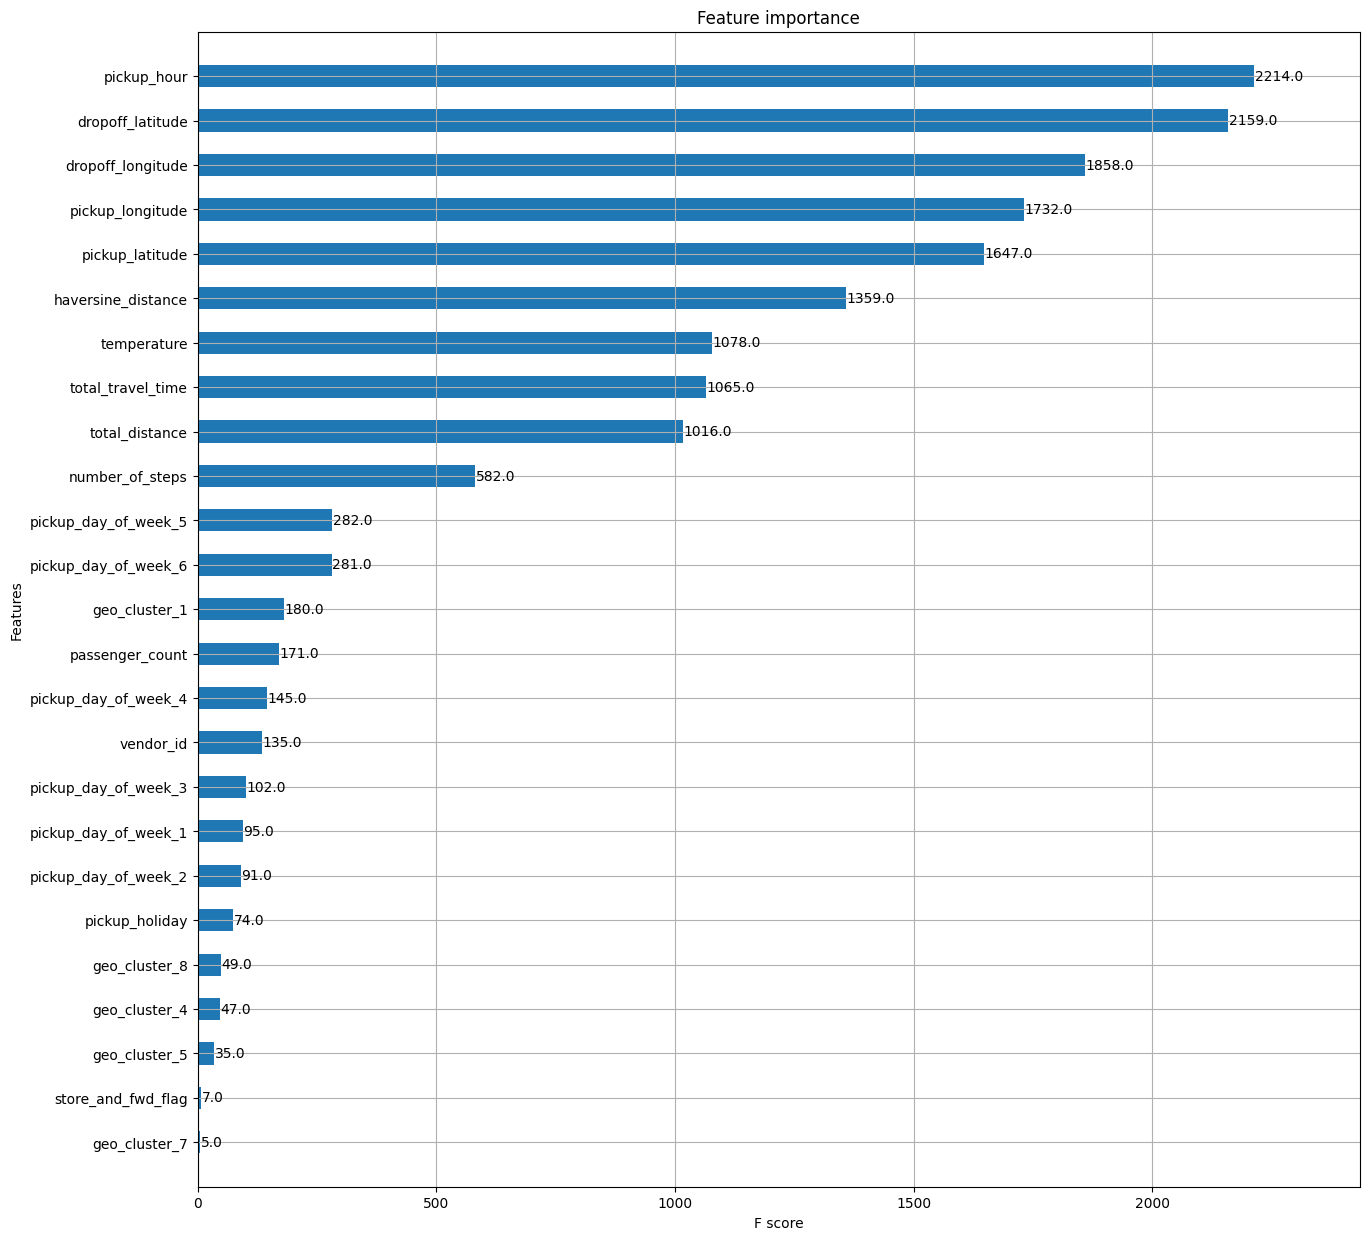

In [90]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

Примеры других решений на Kaggle: https://www.kaggle.com/code/jeffreycbw/nyc-taxi-trip-public-0-37399-private-0-37206 , https://www.kaggle.com/code/au1206/nyc-taxi-duration-prediction-using-xgboost